In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.applications import EfficientNetB6, ResNet50, VGG16
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [4]:
base_dir = '../data/telemoji/pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


In [5]:
## 다른 모델 논문 참고 모델
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', 
                 input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer=Nadam(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0

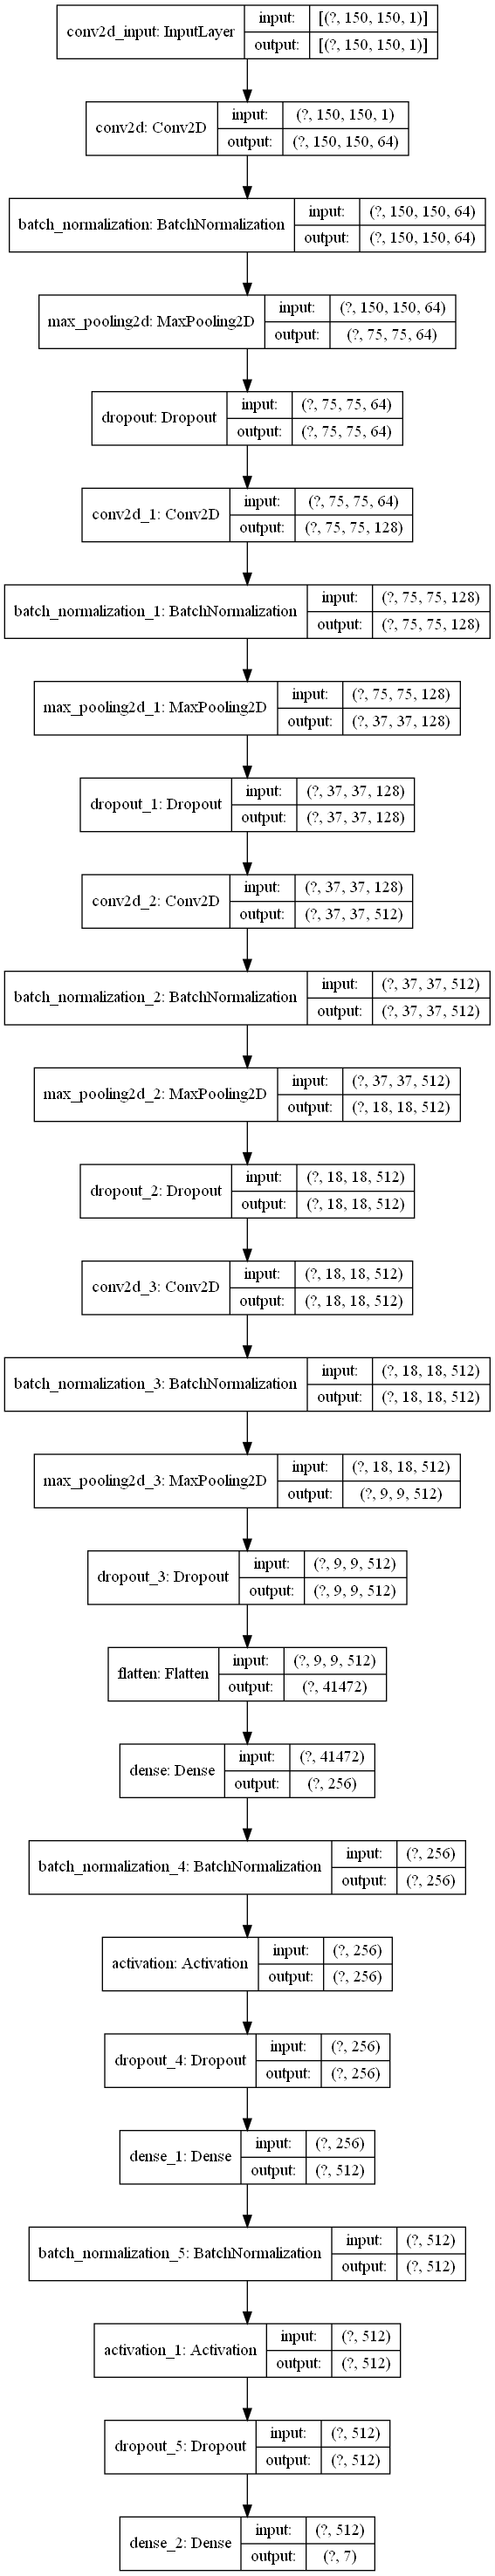

In [6]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='../data/models/논문1_5.png')

In [7]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=30,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/30
159/159 [==============================] - 49s 307ms/step - loss: 2.2108 - accuracy: 0.2376 - val_loss: 1.9246 - val_accuracy: 0.2864
Epoch 2/30
159/159 [==============================] - 48s 299ms/step - loss: 1.9602 - accuracy: 0.3203 - val_loss: 1.8627 - val_accuracy: 0.2867
Epoch 3/30
159/159 [==============================] - 49s 306ms/step - loss: 1.7982 - accuracy: 0.3677 - val_loss: 1.8370 - val_accuracy: 0.3400
Epoch 4/30
159/159 [==============================] - 49s 306ms/step - loss: 1.6775 - accuracy: 0.4015 - val_loss: 1.6744 - val_accuracy: 0.3877
Epoch 5/30
159/159 [==============================] - 49s 307ms/step - loss: 1.5452 - accuracy: 0.4443 - val_loss: 1.6040 - val_accuracy: 0.4197
Epoch 6/30
159/159 [==============================] - 48s 305ms/step - loss: 1.4392 - accuracy: 0.4789 - val_loss: 1.4828 - val_accuracy: 0.4533
Epoch 7/30
159/159 [==============================] - 46s 292ms/step - loss: 1.3417 - accuracy: 0.5132 - val_loss: 1.4561 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


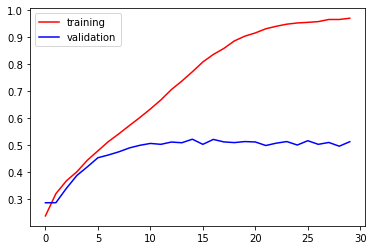

In [8]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('../data/models/논문1_5_acc.jpg')
plt.show()

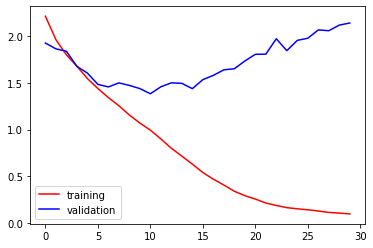

In [9]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('../data/models/논문1_5_val.jpg')
plt.show()

In [10]:
result = model.evaluate(test_generator)
print(np.round(result,4))

21/21 [==============================] - 2s 92ms/step - loss: 1.9409 - accuracy: 0.5574
[1.9409 0.5574]


In [11]:
model.save('../data/models/논문1_5.h5')